Pattern and Anomaly Detection Lab Experiment 5

## Data Stationarity and Smoothening

Reeha Parkar

IBM AIML Batch - AIML1

BE Electronics 

**60001180046**

In [ ]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
import io

In [ ]:
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ads.csv to ads (1).csv


In [ ]:
ads_with_dates_unparsed = pd.read_csv(io.BytesIO(uploaded['ads.csv']))
print(ads_with_dates_unparsed.head())

                  Time     Ads
0  2017-09-13T00:00:00   80115
1  2017-09-13T01:00:00   79885
2  2017-09-13T02:00:00   89325
3  2017-09-13T03:00:00  101930
4  2017-09-13T04:00:00  121630


In [ ]:
ads = pd.read_csv(io.BytesIO(uploaded['ads.csv']), index_col=['Time'], parse_dates=['Time']) # parse_dates with separate date and time from the column automatically
print(ads.head())

                        Ads
Time                       
2017-09-13 00:00:00   80115
2017-09-13 01:00:00   79885
2017-09-13 02:00:00   89325
2017-09-13 03:00:00  101930
2017-09-13 04:00:00  121630


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving currency.csv to currency (1).csv


In [ ]:
currency = pd.read_csv(io.BytesIO(uploaded['currency.csv']),index_col=['Time'], parse_dates=['Time'])
print(currency.head())

            GEMS_GEMS_SPENT
Time                       
2017-05-01          1199436
2017-05-02          1045515
2017-05-03           586111
2017-05-04           856601
2017-05-05           793775


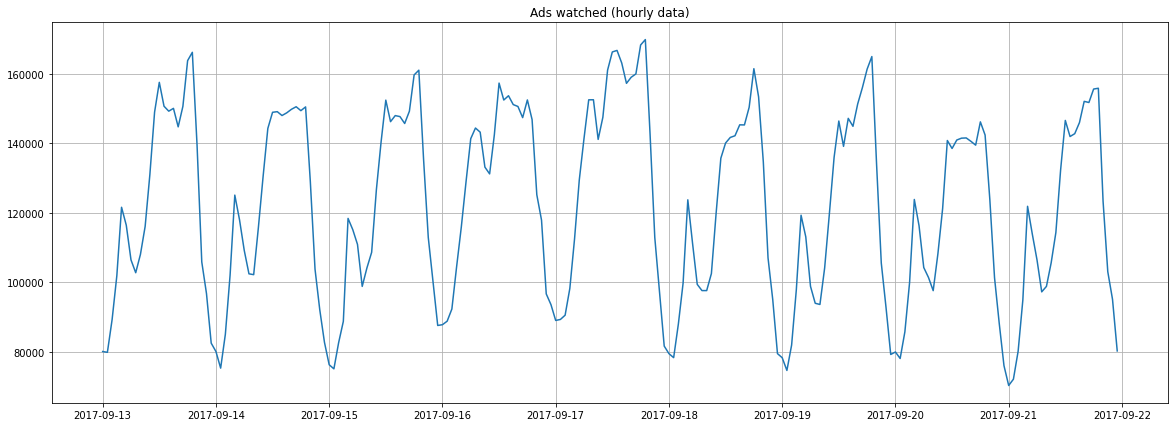

In [ ]:
plt.figure(figsize=(20, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

### Inference

People watch more ads by the end of the day

At one point in the morning, decent number of ads are watched

Least number of ads watched at midnight

And the distribution for each day is fairly similar


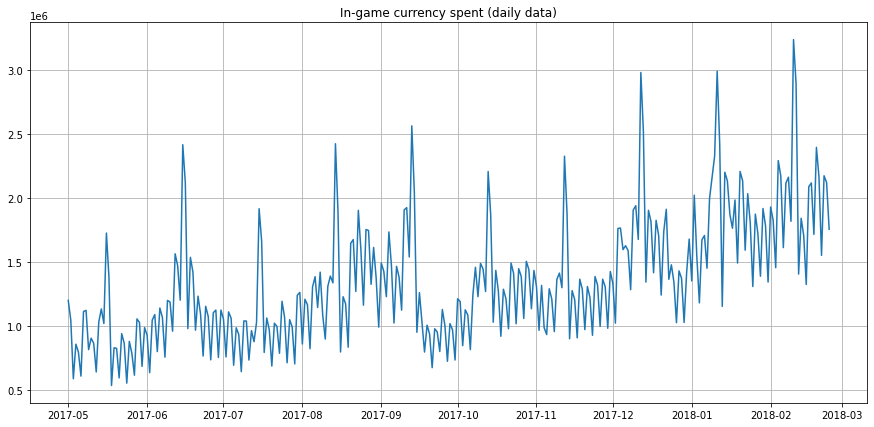

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

### Inference

Inconsistent distribution of money spent

Gradually increasing each month

There is a peak around the middle of each month

# ▶ Values used and their sklearn functions:

R squared: coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), (−∞,1]



sklearn.metrics.r2_score

    Mean Absolute Error: this is an interpretable metric because it has the same unit of measurment as the initial series, [0,+∞)



sklearn.metrics.mean_absolute_error

    Median Absolute Error: again, an interpretable metric that is particularly interesting because it is robust to outliers, [0,+∞)



sklearn.metrics.median_absolute_error

    Mean Squared Error: the most commonly used metric that gives a higher penalty to large errors and vice versa, [0,+∞)



sklearn.metrics.mean_squared_error

    Mean Squared Logarithmic Error: practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, [0,+∞)



sklearn.metrics.mean_squared_log_error

    Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, [0,+∞)



In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

In [ ]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100


Move, smoothe, evaluate

Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like y^t=yt−1
(which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its k previous values. Therefore, we will use the moving average.

In [ ]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(ads, 24) # prediction for the last observed day (past 24 hours)

116805.0

In [ ]:
# This means that tomorrow's value would be today's average value
# So for the next day after the last day in the dataset,
# the ads watched will be equal to the average of the previous 24 hours
# But we would require every immediate pastday data, which is not possible

Unfortunately, we cannot make predictions far in the future -- in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with DataFrame.rolling(window).mean(). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [ ]:
# window = data of how many days is to be averaged
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


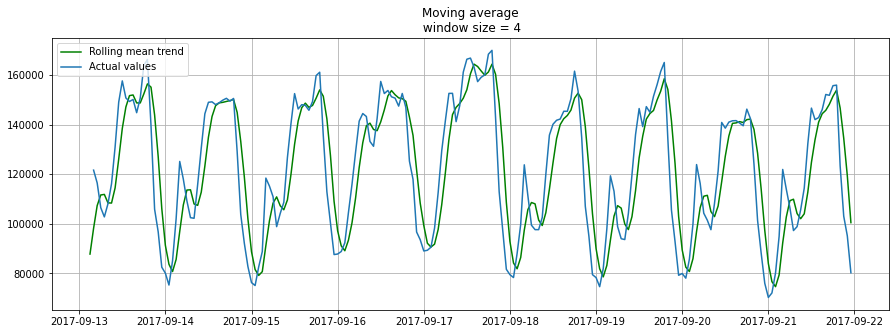

In [ ]:
plotMovingAverage(ads, 4) 
# greater the window, more inaccurate predictions
# but with 1/2 window, it is more of memorization than prediction, so 4

Now let's try smoothening by the previous 24 hours.

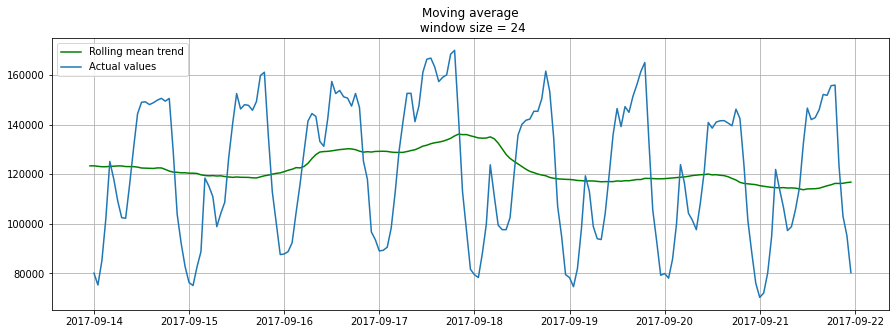

In [ ]:
plotMovingAverage(ads, 24)

When we applied daily smoothing on hourly data, we could clearly see the dynamics of ads watched. During the weekends, the values are higher (more time to play on the weekends) while fewer ads are watched on weekdays.

(16 and 17th September 2017 = weekend)

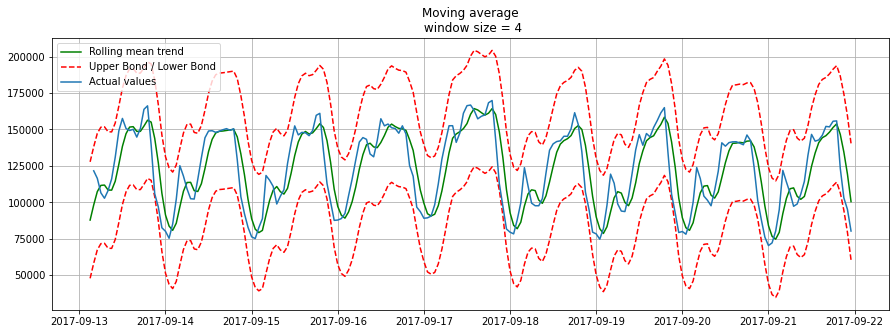

In [ ]:
plotMovingAverage(ads, 4, plot_intervals=True)

Now, let's create a simple anomaly detection system with the help of moving average. Unfortunately, in this particular dataset, everything is more or less normal, so we will intentionally make one of the values abnormal in our dataframe ads_anomaly

In [ ]:
# Adding anomzaly to the data
ads_anomaly = ads.copy()
ads_anomaly.iloc[-50] = ads_anomaly.iloc[-50] * 0.2 # say we have 80% drop of ads 

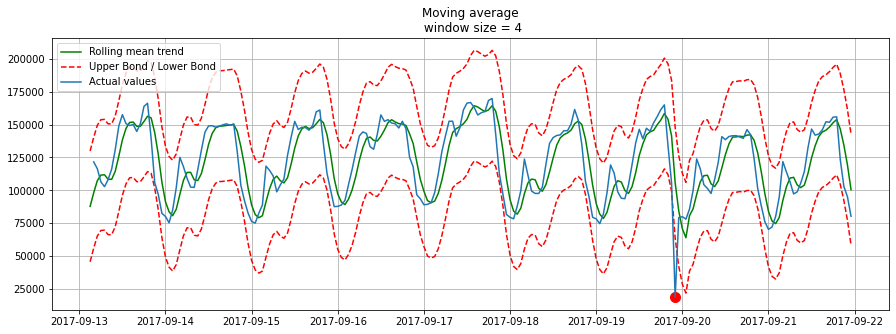

In [ ]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)
# can see the anomaly

# Now smoothening the currency graph

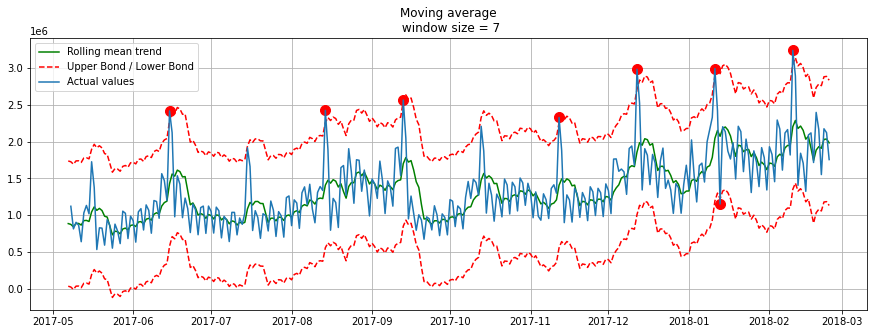

In [ ]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True) # weekly smoothing

Oh no, this was not as great! Here, we can see the downside of our simple approach -- it did not capture the monthly seasonality in our data and marked almost all 30-day peaks as anomalies. If you want to avoid false positives, it is best to consider more complex models.

# Weighted Average

Weighted average is a simple modification to the moving average. The weights sum up to 1 with larger weights assigned to more recent observations.


In [ ]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [ ]:
weighted_average(ads, [0.6, 0.3, 0.1]) # descending order, and weights should add upto 1

87025.5

# Exponential smoothing

Now, let's see what happens if, instead of weighting the last k values of the time series, we start **weighting all available observations while exponentially decreasing the weights as we move further back in time**. There exists a formula for exponential smoothing that will help us with this:

Here the model value is a weighted average between the current true value and the previous model values. The α
weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller α is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function -- we multiply by (1−α) each time, which already contains a multiplication by (1−α) of previous model values.

In [ ]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

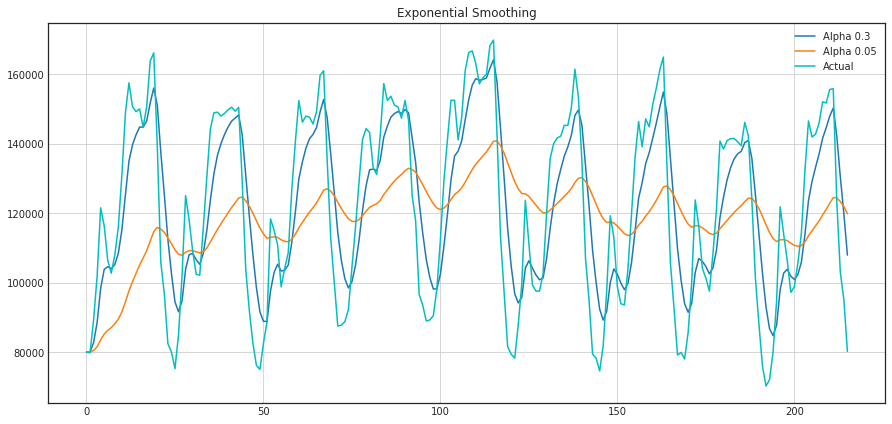

In [ ]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])

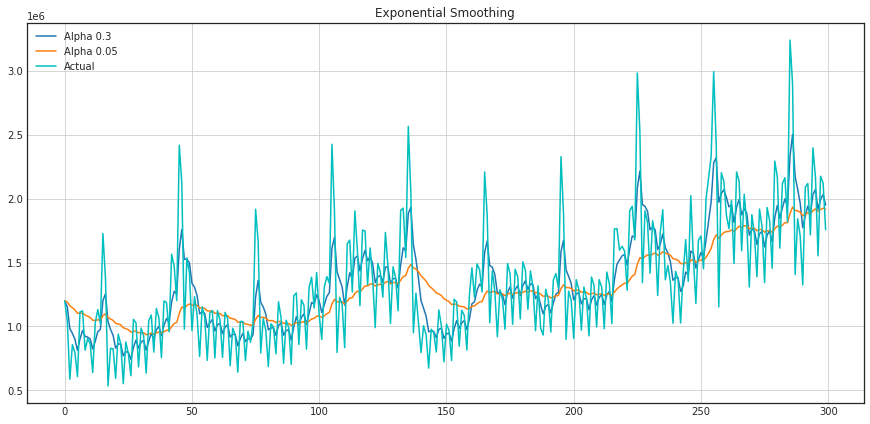

In [ ]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

# Double exponential smoothing

Up to now, the methods that we've discussed have been for a single future point prediction (with some nice smoothing). That is cool, but it is also not enough. Let's extend exponential smoothing so that we can predict two future points (of course, we will also include more smoothing).

Series decomposition will help us -- we obtain two components: intercept (i.e. level) ℓ
and slope (i.e. trend) b. We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:
The first one describes the intercept, which, as before, depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the β coefficient is a weight for exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

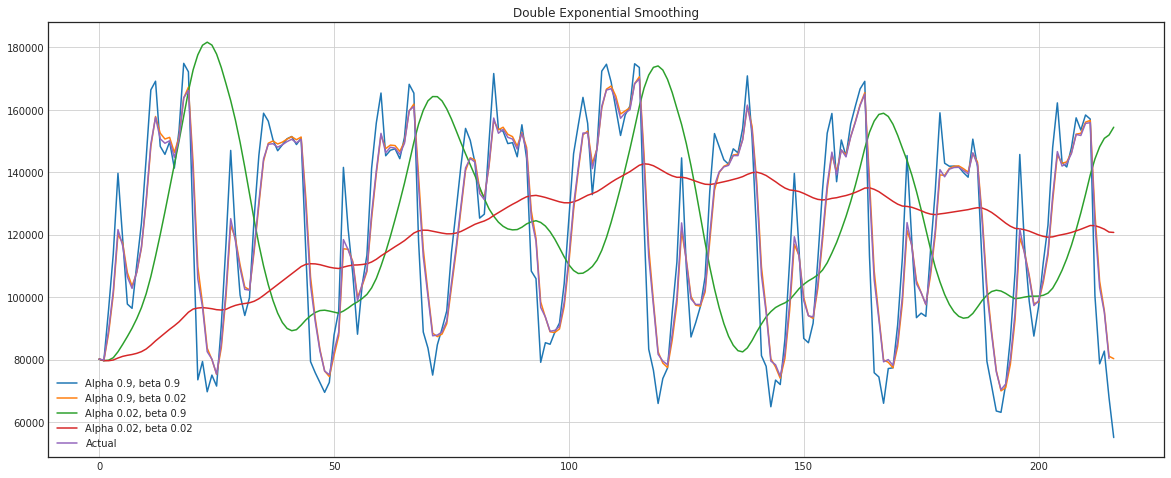

In [ ]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [ ]:
# alpha = 0.9, and beta = 0.9 works better than the others in this case, orange is just overfitting
# red and green gives an overview nature of the graph

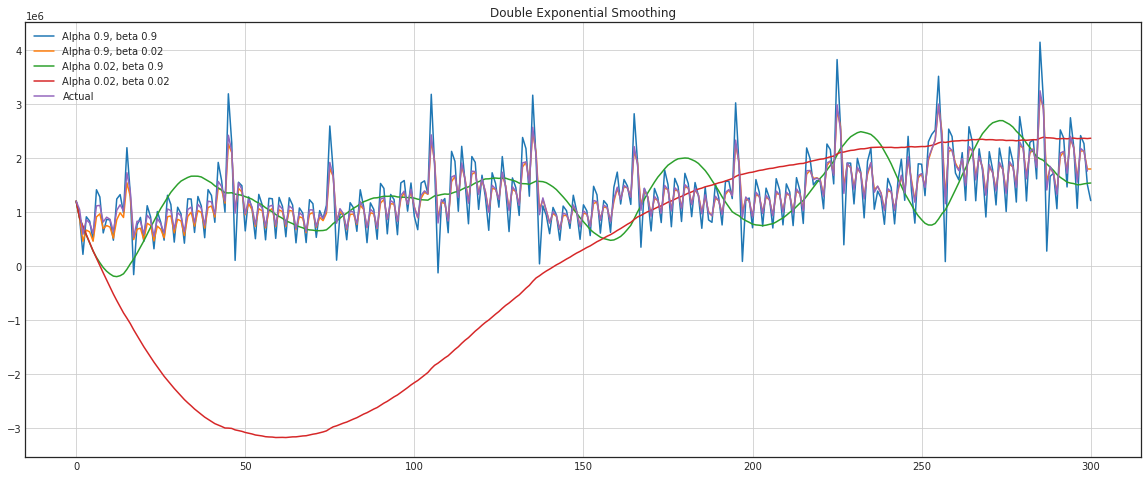

In [ ]:
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

Now we have to tune two parameters: α and β. The former is responsible for the series smoothing around the trend, the latter for the smoothing of the trend itself. The larger the values, the more weight the most recent observations will have and the less smoothed the model series will be. Certain combinations of the parameters may produce strange results, especially if set manually (red and green).